In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
from layers import FreeSpacePropagation
import time
import pandas as pd
from cxlayers import AngularSpectrum, ImageResizing, InputToCx, ImageBinarization, CxMO, CxD2NNFaradayRotation, CxD2NNIntensity, D2NNMNISTDetector, Polarizer

plt.rcParams["font.size"]=18

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [3]:
train_num = 10
test_num = 10
total = train_num + test_num
train_data = {}
test_data = {}
for i in range(10):
  train_data[str(i)] = x_train[np.where(y_train == i)][0:train_num]
  test_data[str(i)] = x_test[np.where(y_test == i)][0:test_num]

In [4]:
inputs = tf.keras.Input((28, 28))
x = ImageResizing((100, 100))(inputs)
x = ImageBinarization(0.5, 0.0, 1.0)(x)
x = InputToCx((100, 100))(x)
x = CxMO((100, 100))(x)
x = AngularSpectrum((100, 100), 633e-9, 0.5e-3, d=2.0e-6, method='band_limited')(x)
# x = CxMO((100, 100))(x)
# x = AngularSpectrum((100, 100), 633e-9, 2.5e-3, d=2.0e-6, method='band_limited')(x)
x = CxD2NNFaradayRotation((100, 100), activation='minmax')(x)
# x = Polarizer((100, 100), phi=0.0)(x)
# x = CxD2NNIntensity((100, 100))(x)
# x = D2NNMNISTDetector(10)(x)

model = tf.keras.Model(inputs, x)
model.summary()
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",  # category: sparse_categorical_crossentropy
              metrics=['accuracy'])

epochs = 10
# early_stopping = tf.keras.callbacks.EarlyStopping(
#     monitor='accuracy',
#     min_delta=0.05,
#     patience=2,
# )
#
# result = model.fit(x_train,
#                    y_train,
#                    batch_size=64,
#                    epochs=epochs
#                    #callbacks=[early_stopping]
#                    )
#
# path = "trained_model/20220319_1"
# model.save(path)
#
# df = pd.DataFrame(result.history)
# df.to_csv(path + "/history.csv")

Metal device set to: Apple M1


2022-03-28 14:49:56.016292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-28 14:49:56.016409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 image_resizing (ImageResizi  (None, 100, 100)         0         
 ng)                                                             
                                                                 
 image_binarization (ImageBi  (None, 100, 100)         0         
 narization)                                                     
                                                                 
 input_to_cx (InputToCx)     (None, 2, 2, 100, 100)    0         
                                                                 
 cx_mo (CxMO)                (None, 2, 2, 100, 100)    10000     
                                                                 
 angular_spectrum (AngularSp  (None, 2, 2, 100, 100)   0     

In [5]:
start = time.perf_counter()
pred = model.predict(test_data['7'])
print(time.perf_counter()-start)

2022-03-28 14:49:59.142671: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-28 14:49:59.241180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


0.4869155420000002


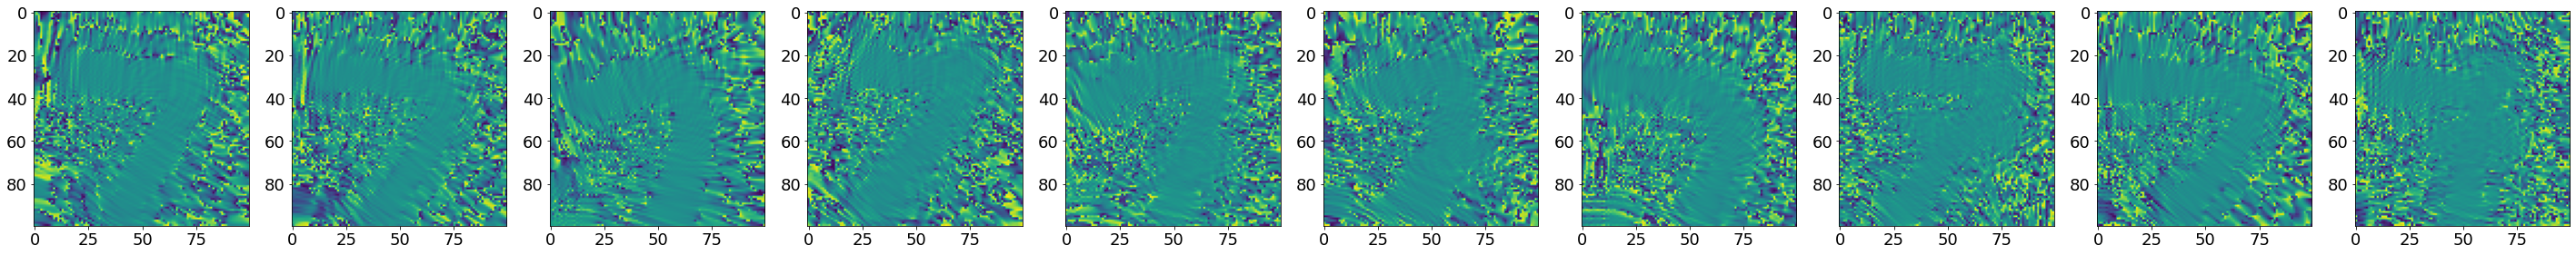

In [13]:
fig, axes = plt.subplots(1, pred.shape[0], figsize=(5*pred.shape[0], 5))
for i, ax in enumerate(axes):
    ax.imshow(pred[i,:,:])

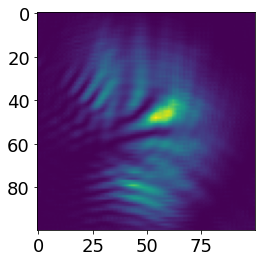

In [578]:
plt.imshow(pred[1,:,:])

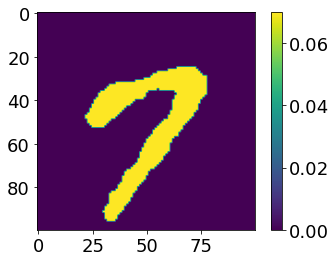

In [6]:
phase = np.loadtxt('data/phase/100px/train_7.csv')
phase = phase * 4 * np.pi / 180
model.layers[4].set_weights([phase])

plt.imshow(model.layers[4].get_weights()[0])
plt.colorbar()

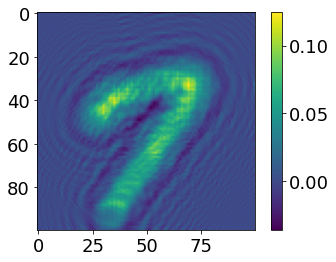

In [7]:
ones = np.ones([1, 28, 28])
pred = model.predict(ones)
plt.imshow(pred[0,:,:])
plt.colorbar()

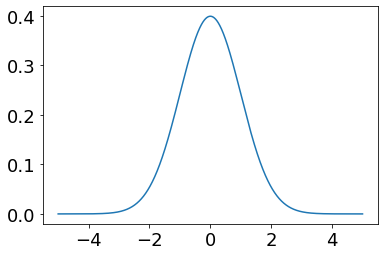

In [203]:
x = np.linspace(-5, 5, 4000)
sig = 1

fx = 1 / (np.sqrt(2*np.pi*sig**2)) * np.exp(-x**2/(2*sig**2))
plt.plot(x, fx)

/Users/takumi/miniforge3/envs/tensorflow25/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


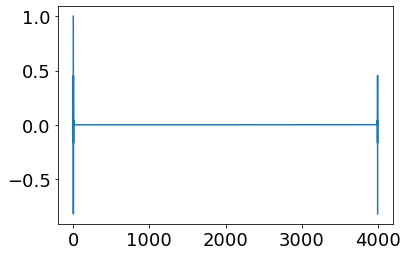

In [217]:
fk = tf.signal.fft(fx) / 400
plt.plot(fk)

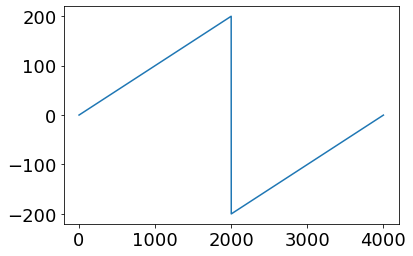

In [218]:
freq = np.fft.fftfreq(4000, d=10/4000)
plt.plot(freq)

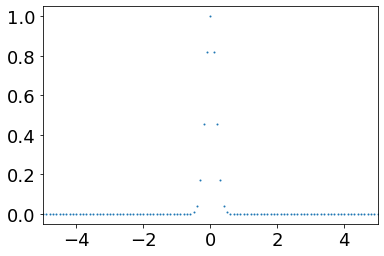

In [219]:
plt.xlim([-5, 5])
plt.scatter(freq, tf.abs(fk), s=1)

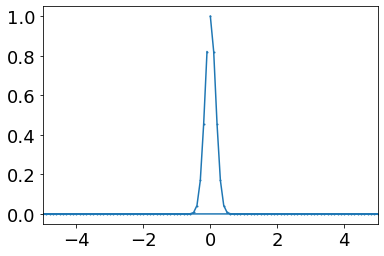

In [225]:
plt.xlim([-5,5])
plt.scatter(freq, tf.abs(fk),s=1)
theory = np.exp(-(2*np.pi*freq)**2 * sig**2 / 2)
plt.plot(freq, theory)

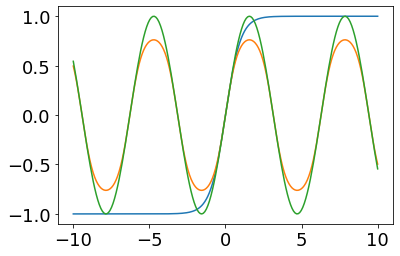

In [20]:
x = np.linspace(-10, 10, 200)
tanh = np.tanh(x)
cycle_tanh = np.tanh(np.sin(x))
sin = np.sin(x)
plt.plot(x, tanh)
plt.plot(x, cycle_tanh)
plt.plot(x, sin)